# Build a predictive maintenance model for a delivery company - Classification

### (Bir teslimat şirketi için kestirimci bakım  modeli oluşturma – Sınıflandırma)
* Bir aracın / ekipmanın arıza yapıp yapmayacağını önceden tahmin etmek

<img src= "https://www.infinite-uptime.com/wp-content/uploads/2024/08/AI-Predictive-Maintenance.jpg" width="800" height="500">

## 🎯 Proje Amacı

Bu projenin amacı, bir teslimat şirketine ait geçmiş sensör ve operasyonel veriler kullanılarak **kestirimci bakım (predictive maintenance)** için bir **sınıflandırma modeli** geliştirmektir. Çalışmada, ekipman veya araçlarda bir arıza oluşup oluşmayacağı önceden tahmin edilmeye çalışılmıştır.

Veri seti incelendiğinde, arıza durumlarını temsil eden sınıfın oldukça az sayıda gözlem içerdiği ve bu nedenle problemin **imbalanced classification** kapsamında olduğu tespit edilmiştir. Bu durum, geleneksel makine öğrenmesi yaklaşımlarının azınlık sınıfı yeterince öğrenememesine neden olmaktadır.

Bu çalışmada, veri dengesizliği problemini gidermek amacıyla **SMOTE** yöntemi kullanılmış ve model performansı doğruluk yerine **recall, F1-score ve ROC-AUC** gibi daha anlamlı metrikler ile değerlendirilmiştir. Böylece, özellikle arıza durumlarının kaçırılmaması hedeflenmiş ve gerçek dünya uygulamalarına uygun bir çözüm sunulmuştur.

In [1]:
import sys
print(sys.executable)

C:\Users\leyuz\anaconda3\envs\pm\python.exe


In [2]:
import sklearn, imblearn
print("sklearn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)

sklearn: 1.2.2
imblearn: 0.10.1


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df= pd.read_csv("failure.csv")

In [5]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
df.tail()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0


In [7]:
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [9]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [10]:
df.shape

(124494, 12)

<Axes: >

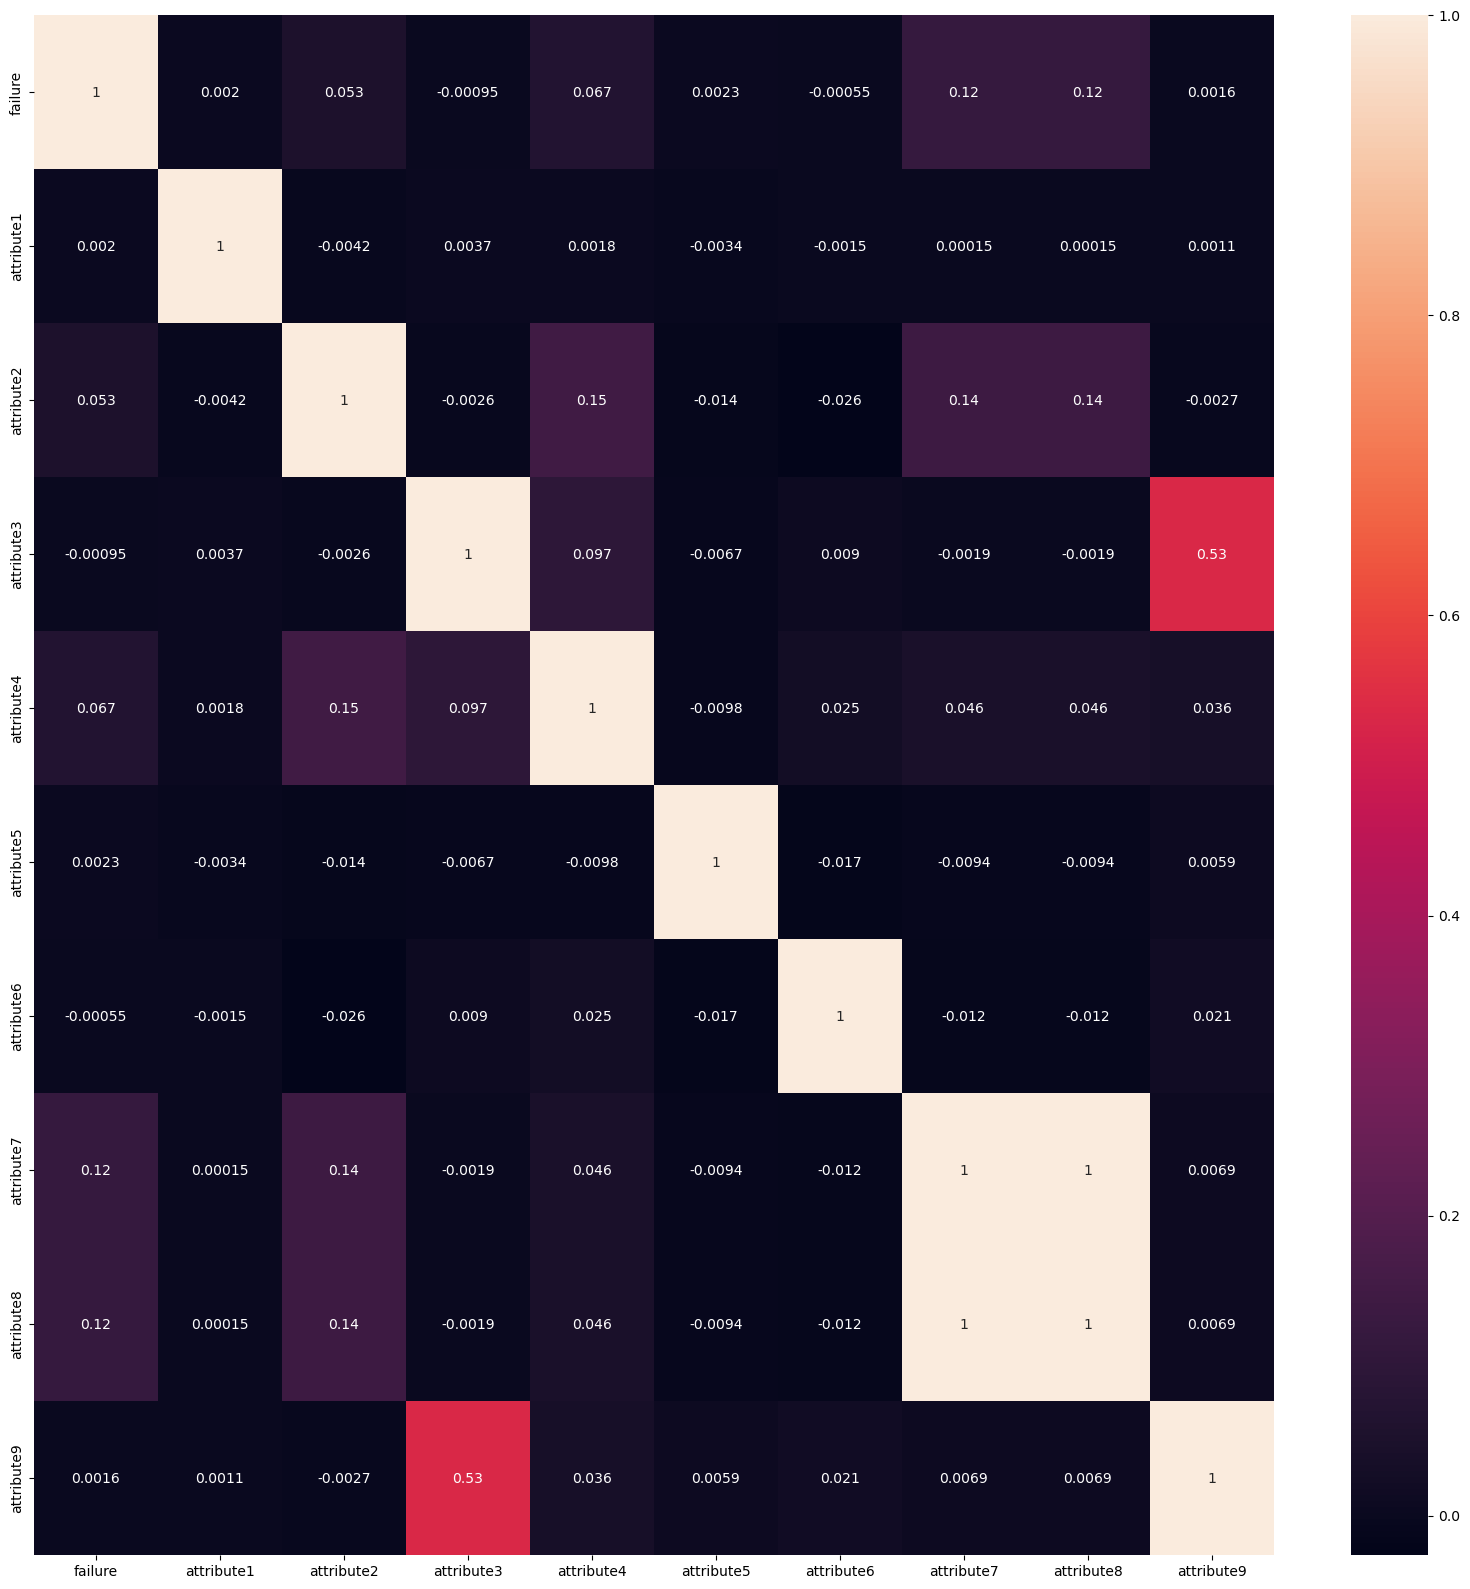

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [12]:
abs(df.corr(numeric_only=True)['failure'].sort_values(ascending=False))

failure       1.000000
attribute7    0.119055
attribute8    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001984
attribute9    0.001622
attribute6    0.000550
attribute3    0.000948
Name: failure, dtype: float64

<Axes: xlabel='attribute1'>

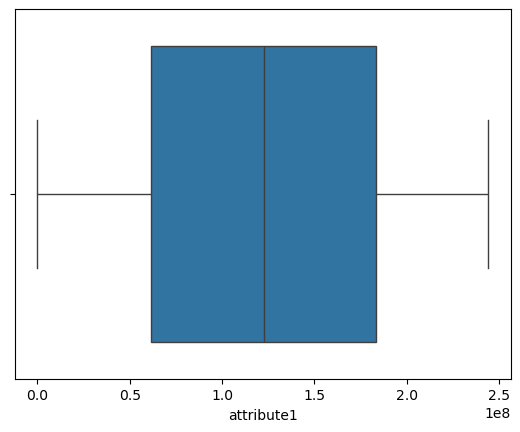

In [13]:
sns.boxplot(x=df['attribute1'])

<Axes: xlabel='attribute2'>

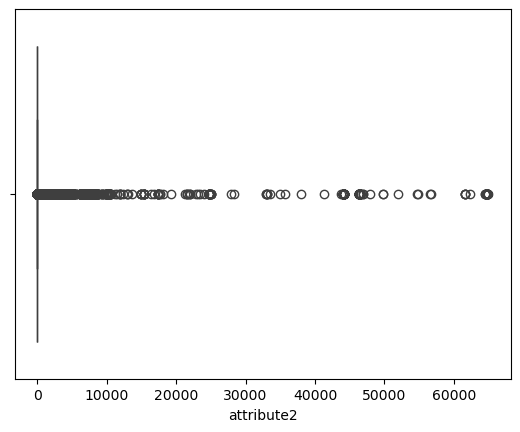

In [14]:
sns.boxplot(x=df['attribute2'])

<Axes: xlabel='attribute3'>

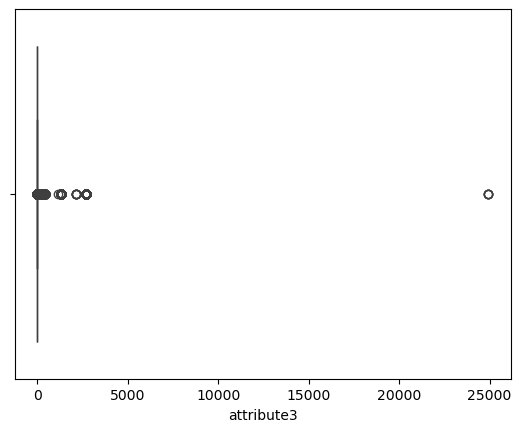

In [15]:
sns.boxplot(x=df['attribute3'])

<Axes: xlabel='failure', ylabel='Density'>

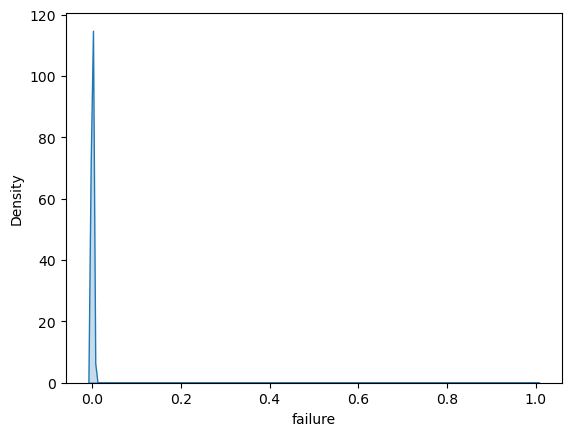

In [16]:
sns.kdeplot(x=df['failure'], fill=True)

In [17]:
df["failure"].value_counts()

failure
0    124388
1       106
Name: count, dtype: int64

In [18]:
df["failure"].value_counts(normalize=True)

failure
0    0.999149
1    0.000851
Name: proportion, dtype: float64

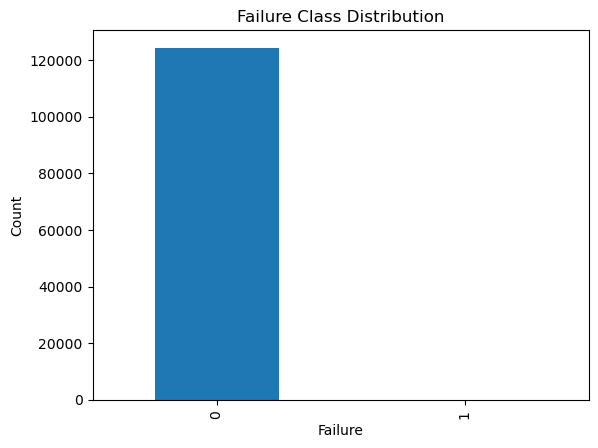

In [19]:
df["failure"].value_counts().plot(kind="bar")
plt.title("Failure Class Distribution")
plt.xlabel("Failure")
plt.ylabel("Count")
plt.show()

### 📊 Failure Değişkeni Dağılımı

Failure değişkeninin dağılımı incelendiğinde, **0 sınıfının (arıza yok)** veri setinin neredeyse tamamını oluşturduğu, **1 sınıfının (arıza var)** ise çok az sayıda gözleme sahip olduğu görülmektedir. Bu durum, veri setinin **yüksek derecede dengesiz (imbalanced)** olduğunu açıkça göstermektedir.

Bu tür dengesiz veri setlerinde, makine öğrenmesi modelleri çoğunluk sınıfına yönelme eğiliminde olmakta ve azınlık sınıfı olan arıza durumlarını öğrenmekte zorlanmaktadır. Bu nedenle, model performansını yalnızca doğruluk (accuracy) metriği ile değerlendirmek yanıltıcı sonuçlara yol açabilmektedir.

Bu problemle başa çıkmak amacıyla, azınlık sınıfın daha iyi temsil edilmesini sağlamak için **SMOTE** gibi veri dengeleme yöntemleri uygulanacaktır.

In [20]:
x = df.drop("failure", axis=1)

In [21]:
y = df["failure"]

In [22]:
x = x.drop(["date", "device"], axis=1)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [25]:
y_train.value_counts()

failure
0    99510
1       85
Name: count, dtype: int64

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [28]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

In [29]:
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [30]:
y_pred_lr = lr.predict(x_test)

In [31]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     24878
           1       0.01      0.38      0.02        21

    accuracy                           0.96     24899
   macro avg       0.50      0.67      0.50     24899
weighted avg       1.00      0.96      0.98     24899



In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
smote = SMOTE(random_state=42)

In [34]:
x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

In [35]:
y_train_sm.value_counts()

failure
0    99510
1    99510
Name: count, dtype: int64

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

In [38]:
rf.fit(x_train_sm, y_train_sm)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [40]:
y_pred = rf.predict(x_test)
y_proba = rf.predict_proba(x_test)[:, 1]

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.09      0.14      0.11        21

    accuracy                           1.00     24899
   macro avg       0.54      0.57      0.55     24899
weighted avg       1.00      1.00      1.00     24899



In [42]:
confusion_matrix(y_test, y_pred)

array([[24846,    32],
       [   18,     3]], dtype=int64)

In [43]:
roc_auc_score(y_test, y_proba)

0.822290874706664

## Model Sonuçlarının Değerlendirilmesi

Bu çalışmada iki farklı sınıflandırma modeli karşılaştırılmıştır:  
- Baseline model olarak **Logistic Regression**  
- Ana model olarak **Random Forest (SMOTE uygulanmış veri ile)**  

Amaç, özellikle **arıza sınıfının (failure=1)** doğru şekilde tespit edilmesini sağlamaktır.

### 1️⃣ Baseline Model: Logistic Regression

Logistic Regression modeli, `class_weight="balanced"` parametresi kullanılarak eğitilmiştir. Bu sayede sınıf dengesizliğinin etkisi kısmen azaltılmaya çalışılmıştır.

**Sonuçlar:**

- Majority sınıf (failure=0) için:
  - Recall: **0.96**
  - F1-score: **0.98**
- Minority sınıf (failure=1) için:
  - Recall: **0.38**
  - F1-score: **0.02**

Bu sonuçlar, modelin genel doğruluk oranı yüksek görünmesine rağmen (**accuracy ≈ 0.96**), arıza sınıfını tespit etmede oldukça zayıf kaldığını göstermektedir. Özellikle failure=1 sınıfı için precision ve F1-score değerlerinin çok düşük olması, modelin pratik kullanımda yetersiz olduğunu ortaya koymaktadır.

Bu durum, dengesiz veri setlerinde yalnızca accuracy metriğine bakmanın yanıltıcı olabileceğini göstermektedir.


### 2️⃣ Ana Model: Random Forest (SMOTE Sonrası)

Random Forest modeli, eğitim verisi üzerinde **SMOTE** uygulanarak eğitilmiştir. Bu sayede azınlık sınıf için sentetik örnekler üretilmiş ve modelin karar sınırlarını daha iyi öğrenmesi sağlanmıştır.

**Sonuçlar:**

- Minority sınıf (failure=1) için:
  - Precision: **0.09**
  - Recall: **0.14**
  - F1-score: **0.11**
- ROC-AUC skoru: **0.82**

Confusion matrix sonuçlarına göre model:
- 21 gerçek arıza örneğinin **3 tanesini doğru tahmin edebilmiştir**
- 18 arıza vakası kaçırılmıştır (false negative)

Her ne kadar minority sınıf için recall değeri düşük görünse de, ROC-AUC skorunun **0.82** olması, modelin sınıfları ayırt etme kapasitesinin güçlü olduğunu göstermektedir. Bu da eşik değeri ayarlaması yapılarak arıza yakalama oranının artırılabileceğini göstermektedir.

### 3️⃣ Genel Değerlendirme ve Yorum

- Logistic Regression modeli, baseline olarak kullanılmış ve sınıf dengesizliğinin model performansını nasıl etkilediğini göstermiştir.
- SMOTE + Random Forest yaklaşımı, arıza sınıfını öğrenme konusunda daha anlamlı bir performans sunmuştur.
- Bu problem bağlamında **recall ve ROC-AUC**, accuracy’ye kıyasla çok daha kritik metriklerdir.
- Gerçek dünya senaryolarında arızaların kaçırılmaması daha önemli olduğu için, eşik değeri düşürülerek recall artırılabilir.

Sonuç olarak, **SMOTE destekli Random Forest modeli**, dengesiz veri setleri için Logistic Regression modeline kıyasla daha uygun bir çözüm sunmaktadır.